### The Ljungan River: Holmsjön and Flasjön  

In this Notebook we get an overview of the inflow Data for the Flasjön and Holmsjön Reservoirs in the Ljungan River. The reservoirs are yearly regulating reservoirs in which nominations are made for discharge by the power producers.  

The goals of this file are to:  

-Get an Overview of the Reservoir Data and prepare it accordingly  
-Visualize Historic Data: Reservoir Levels over time, Inflow and inflow changes, Discharges  
-Fit Statistical Model to Reservoir Levels/Inflow 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from pathlib import Path

In [2]:
dirname = Path.cwd()
print(dirname)
d = os.path.join(dirname, 'Data\\Inflow\\Data from Flasjoen and Holmsjoen.xlsx')
print(d)

c:\Users\lenna\OneDrive - NTNU\Code Master Thesis\Inflow Forecasting
c:\Users\lenna\OneDrive - NTNU\Code Master Thesis\Inflow Forecasting\Data\Inflow\Data from Flasjoen and Holmsjoen.xlsx


In [3]:
c_names = ["Date", "Flasjon Water Level", "Flasjon Volume", "Flasjon Inflow", "Flasjon discharge", "Holmsjon Water Level", "Holmsjon Volume", "Holmsjon Inflow", "Holmsjon Discharge"]
df = pd.read_excel(d, header=0, names=c_names, index_col=0)

df.head()

,Flasjon Water Level,Flasjon Volume,Flasjon Inflow,Flasjon discharge,Holmsjon Water Level,Holmsjon Volume,Holmsjon Inflow,Holmsjon Discharge
Date,,,,,,,,
2006-01-01,484.00,2087.0,12.8,49.0,244.39,1928,13.6,53.2
2006-01-02,483.83,2056.0,13.6,49.0,244.42,1947,22.7,89.1
2006-01-03,483.69,2031.0,10.2,49.0,244.41,1941,13.4,85.9
2006-01-04,483.52,2000.0,10.2,50.0,244.41,1941,23.0,88.1
2006-01-05,483.34,1968.0,8.2,52.0,244.41,1941,15.0,86.2


In [4]:
df.describe()

,Flasjon Water Level,Flasjon Volume,Flasjon Inflow,Flasjon discharge,Holmsjon Water Level,Holmsjon Volume,Holmsjon Inflow,Holmsjon Discharge
count,6397.000000,6397.000000,6396.000000,6396.000000,6397.000000,6397.000000,6397.000000,6396.000000
mean,485.376625,2562.251898,26.030604,25.827359,243.517652,1440.118180,42.788698,68.548669
std,7.664080,1300.114872,32.851041,21.299452,1.095048,596.894627,48.478196,33.327018
min,465.370000,15.200000,-2.640000,0.000000,240.460000,5.000000,-48.200000,9.300000
25%,480.190000,1445.000000,8.030000,0.170000,242.830000,1029.000000,14.000000,43.790000
50%,487.800000,2833.000000,14.240000,25.325000,243.970000,1675.000000,30.800000,66.000000
75%,491.490000,3654.000000,29.232500,47.102500,244.320000,1886.000000,57.500000,87.695000
max,495.200000,4602.000000,340.990000,74.000000,244.850000,2216.000000,423.600000,350.410000


array([<Axes: xlabel='Data', ylabel='Volume [Mm^3]'>,
       <Axes: xlabel='Data', ylabel='Volume [Mm^3]'>], dtype=object)

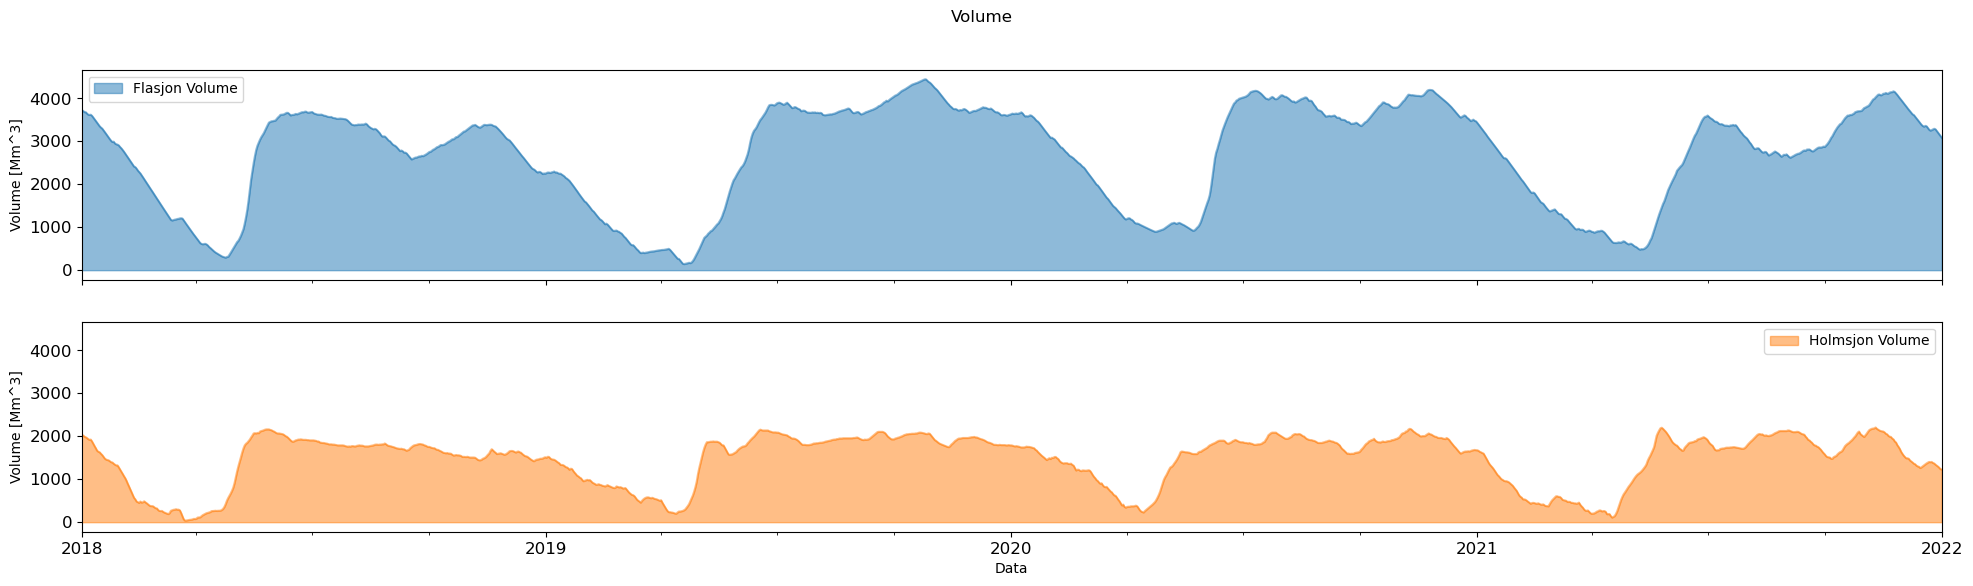

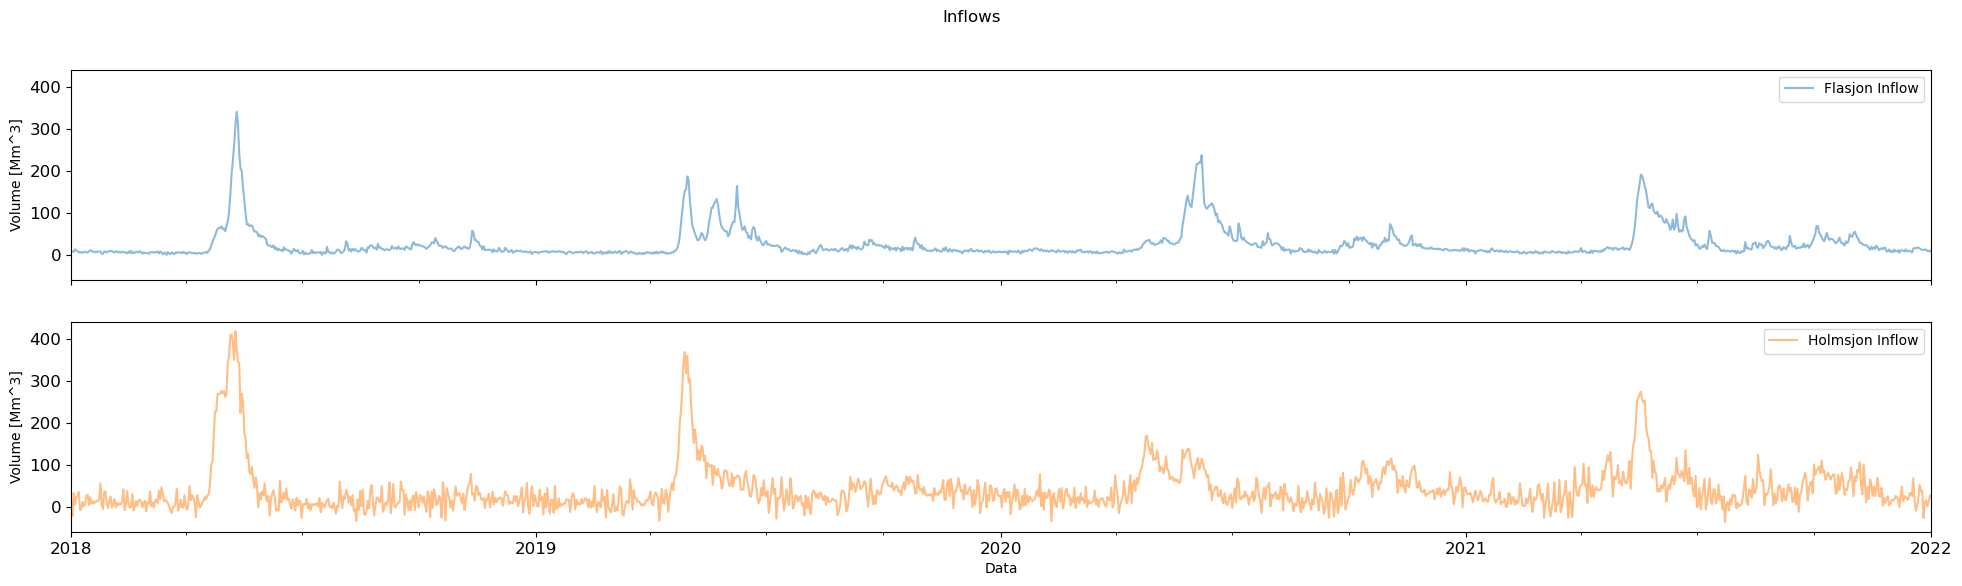

In [5]:
start_date, end_date = "2018-01-01", "2022-01-01"
volumes = df[["Flasjon Volume", "Holmsjon Volume"]]
inflows = df[["Flasjon Inflow", "Holmsjon Inflow"]]
volumes.loc[start_date : end_date].plot(kind="area", xlabel="Data", ylabel="Volume [Mm^3]", figsize=(24,6), subplots=True, sharey=True, title="Volume", fontsize=12, alpha=0.5 )
inflows.loc[start_date : end_date].plot(xlabel="Data", ylabel="Volume [Mm^3]", figsize=(24,6), subplots=True, sharey=True, title="Inflows", fontsize=12, alpha=0.5 )

In [6]:
volumes["year"] = volumes.index.get_level_values("Date").year
yearly_volumes_Flasjon = volumes.groupby("year")["Flasjon Volume"].agg(list)
yearly_volumes_Holmsjon = volumes.groupby("year")["Holmsjon Volume"].agg(list)
# mean_volume_Flasjon = yearly_volumes_Flasjon.mean()
# mean_volume_Holmsjon = yearly_volumes_Holmsjon.mean()
print(yearly_volumes_Flasjon)
def mean_curve(dfgroup, colname):
    max_length = max(len(group) for group in dfgroup)
    mean_curve = pd.Series(colname)
    for i in range(max_length):
        groups_to_sum = [group for group in dfgroup if len(group) > i]
        mean_curve.loc[i] = sum(group[i] for group in groups_to_sum)/len(groups_to_sum)
    return mean_curve

mean_volume_Flasjon = mean_curve(yearly_volumes_Flasjon, "Volume")
mean_volume_Holmsjon = mean_curve(yearly_volumes_Holmsjon, "Volume")
print(mean_volume_Flasjon)

year
2006    [2087.0, 2056.0, 2031.0, 2000.0, 1968.0, 1932....
2007    [3801.0, 3767.0, 3732.0, 3699.0, 3664.0, 3631....
2008    [2984.0, 2990.0, 2986.0, 2947.0, 2909.0, 2883....
2009    [2341.0, 2343.0, 2337.0, 2320.0, 2295.0, 2248....
2010    [2516.0, 2494.0, 2466.0, 2430.0, 2426.0, 2397....
2011    [1964.0, 1975.0, 1979.0, 1934.0, 1895.0, 1855....
2012    [3076.0, 3066.0, 3040.0, 3010.0, 2975.0, 2937....
2013    [3487.0, 3480.0, 3453.0, 3441.0, 3439.0, 3420....
2014    [3151.0, 3129.0, 3089.0, 3055.0, 3033.0, 3014....
2015    [3990.0, 4003.0, 4017.0, 4015.0, 4003.0, 3969....
2016    [3356.0, 3368.0, 3361.0, 3329.0, 3293.0, 3251....
2017    [2478.0, 2498.0, 2490.0, 2470.0, 2455.0, 2439....
2018    [3711.0, 3708.0, 3676.0, 3678.0, 3645.0, 3619....
2019    [2261.0, 2272.0, 2272.0, 2261.0, 2276.0, 2282....
2020    [3631.0, 3643.0, 3633.0, 3638.0, 3645.0, 3636....
2021    [3432.0, 3393.0, 3356.0, 3315.0, 3277.0, 3237....
2022    [3081.0, 3063.0, 3057.0, 3023.0, 2984.0, 2945....
2023    [

C:\Users\lenna\AppData\Local\Temp\ipykernel_17112\3093569562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volumes["year"] = volumes.index.get_level_values("Date").year


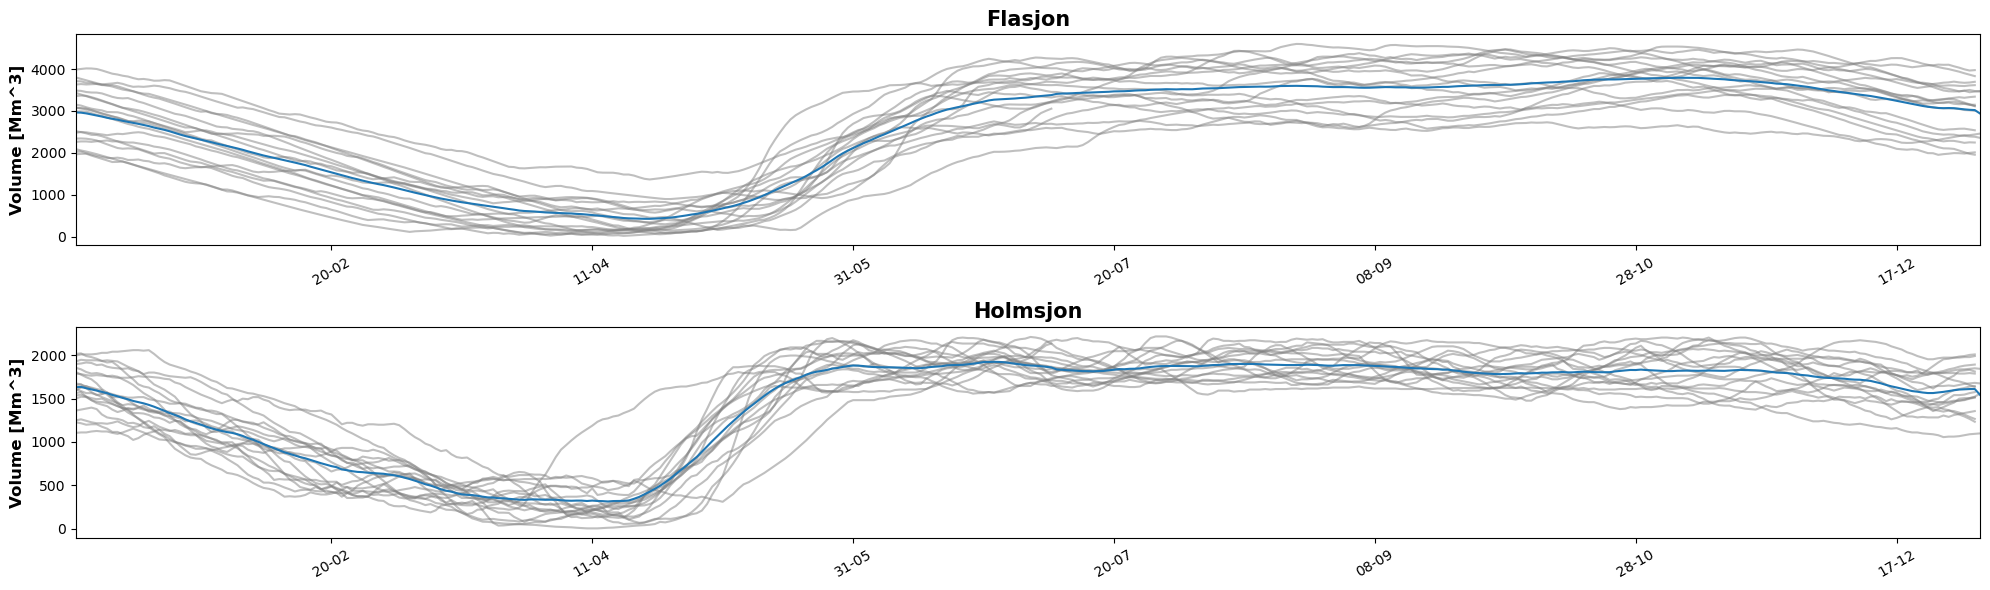

In [7]:
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(20,6))

for year, levels in yearly_volumes_Flasjon.items():
    axs[0].plot(range(1, len(levels) + 1), levels, label=str(year),  color="gray", alpha=0.5)

for year, levels in yearly_volumes_Holmsjon.items():
    axs[1].plot(range(1, len(levels) + 1), levels, label=str(year), color="gray", alpha=0.5)
axs[0].plot(range(1, len(mean_volume_Flasjon) + 1), mean_volume_Flasjon, )
axs[1].plot(range(1, len(mean_volume_Holmsjon) + 1), mean_volume_Holmsjon)
# axs[0].set_xlabel("Date", fontsize = 12, fontweight = "bold")
axs[0].set_ylabel("Volume [Mm^3]", fontsize = 12,fontweight = "bold")
axs[0].set_title("Flasjon", fontsize = 15, fontweight = "bold")
# axs[1].set_xlabel("Date", fontsize = 12, fontweight = "bold")
axs[1].set_ylabel("Volume [Mm^3]", fontsize = 12, fontweight = "bold")
axs[1].set_title("Holmsjon", fontsize = 15, fontweight = "bold")
for ax in axs:
    ax.margins(x=0)
    ax.legend().set_visible(False)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    for l in ax.get_xticklabels():
        l.set_rotation(30)
plt.tight_layout()
plt.show()

In [8]:
inflows["year"] = inflows.index.get_level_values("Date").year
yearly_inflows_Flasjon = inflows.groupby("year")["Flasjon Inflow"].agg(list)
yearly_inflows_Holmsjon = inflows.groupby("year")["Holmsjon Inflow"].agg(list)
# mean_volume_Flasjon = yearly_inflows_Flasjon.mean()
# mean_volume_Holmsjon = yearly_inflows_Holmsjon.mean()
print(yearly_inflows_Flasjon)


mean_inflows_Flasjon = mean_curve(yearly_inflows_Flasjon, "Inflow")
mean_inflows_Holmsjon = mean_curve(yearly_inflows_Holmsjon, "Inflow")
print(mean_inflows_Flasjon)

year
2006    [12.8, 13.6, 10.2, 10.2, 8.2, 7.9, 6.2, 11.2, ...
2007    [16.2, 15.4, 17.4, 15.4, 11.6, 15.3, 9.6, 11.4...
2008    [7.2, 6.2, 7.8, 6.2, 8.2, 6.8, 9.2, 6.2, 7.8, ...
2009    [6.67, 5.8, 11.32, 2.33, 2.68, 6.33, 8.17, 5.9...
2010    [9.9, 9.62, 10.2, 12.65, 8.24, 10.12, 13.49, 9...
2011    [3.5, 5.57, -0.14, 5.25, 6.82, 6.09, 7.48, 1.8...
2012    [4.83, 11.86, 7.62, 12.88, 10.37, 9.71, 6.26, ...
2013    [8.91, 7.66, 4.94, 6.66, 7.82, 6.91, 7.8, 4.27...
2014    [9.1, 9.7, 11.02, 6.05, 8.29, 8.51, 6.29, 8.1,...
2015    [10.3, 11.3, 10.87, 10.52, 10.49, 8.08, 13.42,...
2016    [6.82, 13.75, 8.35, 7.71, 10.29, 7.26, 11.66, ...
2017    [14.23, 14.73, 15.23, 20.95, 9.42, 9.31, 10.6,...
2018    [8.87, 8.13, 7.82, 13.53, 10.84, 8.17, 7.85, 5...
2019    [7.25, 6.3, 4.45, 7.18, 7.35, 7.98, 8.86, 8.99...
2020    [6.6, 7.49, 6.63, 8.21, 6.58, 8.6, 1.86, 10.62...
2021    [11.68, 14.47, 8.08, 11.07, 11.29, 9.05, 10.61...
2022    [11.45, 9.79, 10.25, 11.01, 8.41, 10.72, 8.18,...
2023    [

C:\Users\lenna\AppData\Local\Temp\ipykernel_17112\297390387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inflows["year"] = inflows.index.get_level_values("Date").year


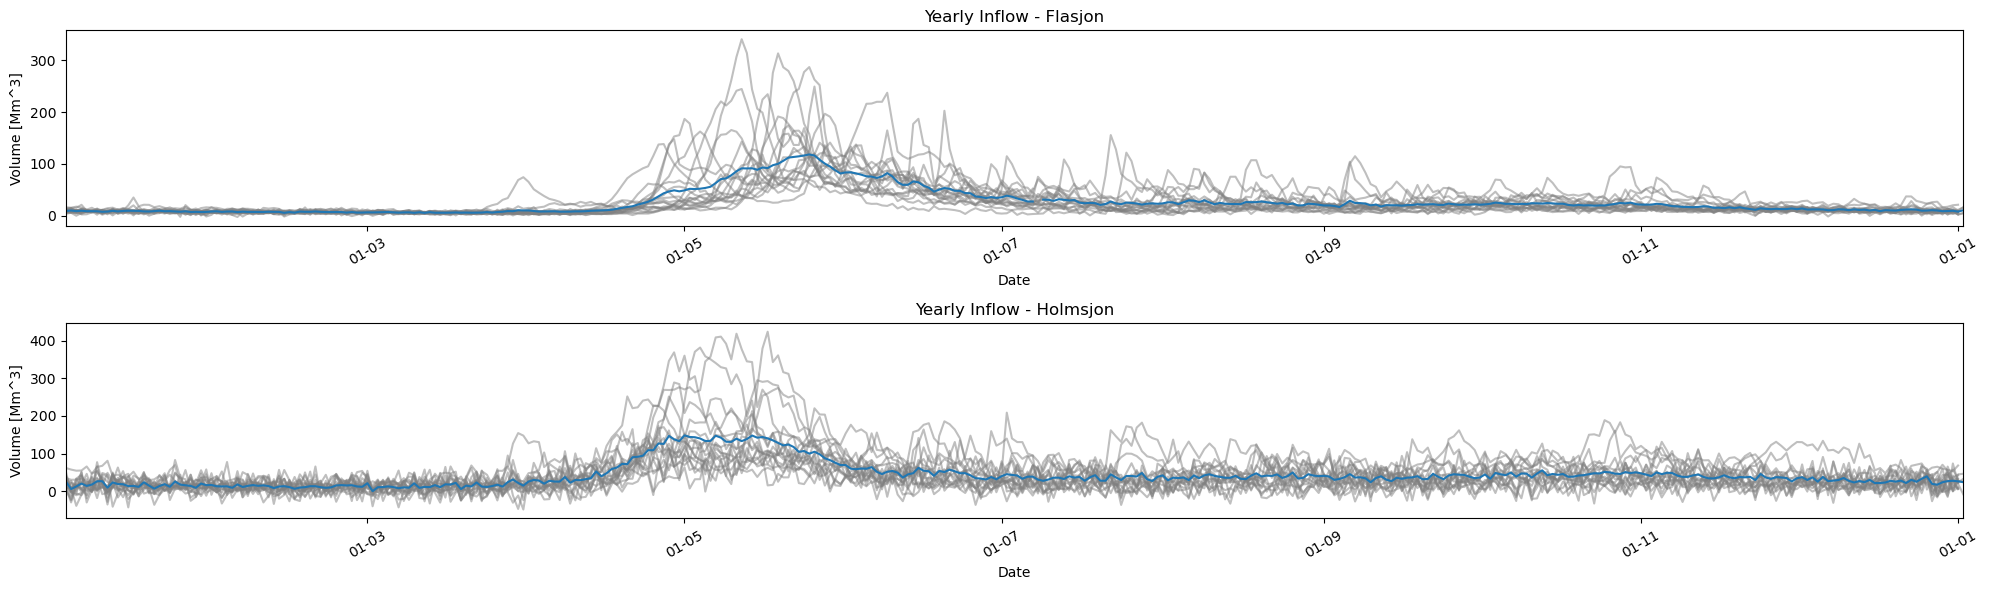

In [9]:
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(20,6))

for year, levels in yearly_inflows_Flasjon.items():
    axs[0].plot(range(1, len(levels) + 1), levels, label=str(year), color="gray", alpha=0.5)

for year, levels in yearly_inflows_Holmsjon.items():
    axs[1].plot(range(1, len(levels) + 1), levels, label=str(year), color="gray", alpha=0.5)
axs[0].plot(range(1, len(mean_inflows_Flasjon) + 1), mean_inflows_Flasjon)
axs[1].plot(range(1, len(mean_inflows_Holmsjon) + 1), mean_inflows_Holmsjon)

axs[0].set_xlabel("Date")
axs[0].set_ylabel("Volume [Mm^3]")
axs[0].set_title("Yearly Inflow - Flasjon")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Volume [Mm^3]")
axs[1].set_title("Yearly Inflow - Holmsjon")
for ax in axs:
    ax.legend().set_visible(False)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    ax.margins(x=0)

for ax in axs:
    for l in ax.get_xticklabels():
        l.set_rotation(30)

fig.tight_layout()
plt.show()

### Save Inflow Data as .csv with mean inflow and mean reservoir levels

We have to save to two files for convenience (dimensions dont match up)
* Original File simply saved as .csv instead of .xlsx, so it can be read into a Julia Dataframe
* Mean Inflows and Reservoir levels as .csv

In [14]:
df_mean = pd.DataFrame()
df_mean['Mean Inflow Flasjon'] = mean_inflows_Flasjon
df_mean['Mean Inflow Holmsjon'] = mean_inflows_Holmsjon
df_mean['Mean Reservoir Level Flasjon'] = mean_volume_Flasjon
df_mean['Mean Reservoir Level Holmsjon'] = mean_volume_Holmsjon
df_mean.to_csv("Data\\Inflow\\CleanInflowData.csv")
df.to_csv("Data\\Inflow\\Data from Flasjoen and Holmsjoen.csv")